# Percentile results
This notebook reflects the results obtained for the psycho network

In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, '../')
from matplotlib import style
style.use('seaborn-poster')

import matplotlib.pyplot as plt, numpy as np, networkx as nx
from Utils.stats import driverNodeEstimate
from Utils import IO

# fn = 'tester.pickle'
fn = '../data2019-11-24T11:30:04.533109.pickle'
fn = '../data2019-11-25T14:50:11.335203.pickle'
fn = '../data2019-11-25T15:46:04.159519.pickle'
fn = '../data2019-11-25T15:57:52.989087.pickle'
fn = '../data2019-11-25T16:28:40.899209.pickle'
for k, v in IO.loadPickle(fn).items():
    print(f'Loading {k}')
    globals()[k] = v

s = next(iter(settings))
setting = settings[s]
centralities = dict(\
                   degree = nx.degree_centrality,\
                   betweenness = nx.betweenness_centrality,\
                   closeness  = nx.closeness_centrality,\
                   eigenvector = nx.eigenvector_centrality,\
                   )

# print(plt.rcParams.keys())
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams['savefig.transparent'] = 1



Loading aucs
Loading data
Loading rdata
Loading settings
Loading coeffs


In [2]:
%load_ext autoreload
%autoreload 2
DRIVERS = {}
alpha = .01
from tqdm import tqdm_notebook as tqdm
from Utils.stats import bootStrapDrivers
N, n = int(1e4), 20

N = int(1e4)

# for all aucs

# from Utils.stats import bootStrapThresholds
alphas = np.linspace(0.1, 1, 10)
alphas  = np.array([0, .05])
structuralData = {}
for k, setting in settings.items():
    m = setting.get('model')
    print(m.mapping)
    g = m.graph
    
    buffer = np.zeros((m.nNodes))
    centData = {}
    for condition, cf in centralities.items():
        c = cf(g)
        for node, val in c.items():
            idx = m.mapping[node]
            buffer[idx] = val
        MAX = buffer.max()
        cdrivers = np.where(buffer == MAX)[0]
#         print(cdrivers, np.where(buffer == MAX))
        print(cdrivers)
        centData[condition] = cdrivers
    structuralData[k] = centData
    
from Utils.stats import returnX
from itertools import product


from Utils.stats import bootStrapAll
boots = {}
alldrivers = {}
total = int(1e4)
batch = setting.get('nTrials')
alpha = .5
for k, v in aucs.items():
    v = np.moveaxis(v, 0, 1) # swap trials and nodes
    print(k, v.shape)
    alldrivers[k] = drivers = bootStrapAll(v, returnX, total, batch, alpha)

    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'depr': 0, 'effort': 1, 'sleep': 2, 'happy': 3, 'lonely': 4, 'enjoy': 5, 'appet': 6, 'sad': 7, 'dislike': 8, 'getgo': 9, 'loss': 10, 'unfr': 11}
[0]
[8]
[0]
[0]
Data/psycho/1548025318.5751357 (20, 12, 3, 3)


<ipython-input-3-3a133d38451b>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


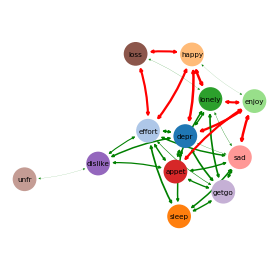

In [3]:
fig, ax = plt.subplots(figsize = (5,5))
from Utils.plotting import addGraphPretty
layout = nx.drawing.nx_agraph.pygraphviz_layout(g, 'neato')
addGraphPretty(g, ax = ax, positions = layout, mapping = m.mapping, annotate = dict(fontsize = .6), circle = dict(radius = 12))
ax.axis('equal')
ax.axis('off')
fig.savefig('pyscho_net.svg', transparent = 1,\
           bbox_inches = 'tight',\
           pad_inches = 0)
fig.show()

In [12]:
from Utils.stats import computeMatchScore
conditions = len(centralities) + 1
# print(alldrivers)
for k, v in alldrivers.items():
    setting = settings.get(k)
    pulses = np.array (setting.get('pulseSizes') )
   
    s = v.shape[:-1]
    npulse, ntemps = s
    tmp = np.array([list(i.keys()) for i in v[...,0].flat], dtype = dict).reshape(s)
    
    ti = np.array([i for i in structuralData[k].values()], dtype = list)
    
    d = np.zeros((conditions + 1, pulses.size, ntemps), dtype = list)
    # print('>', tmp.shape, v.shape)
    d[0] = tmp[1:]
    d[1] = tmp[0]
#     print(d)
#     print(d.shape)
    
    
    s = d.shape
    d = d.reshape(conditions + 1, -1)
    d[2:] = ti
    d = d.reshape(s)
    
    d = d.reshape(-1)
    driverSizes = np.zeros(d.shape)
    for idx, i in enumerate (d):
        try:
            iter(i)
        except:
            d[idx] = [i]
        driverSizes[idx] = len(d[idx])
        
    d = d.reshape(s)
    driverSizes = driverSizes.reshape(s)
#     print(ti, tmp.shape)
    overlap = computeMatchScore(d)

print('>>', overlap.shape)

>> (6, 2, 3)


(6, 2, 3)
['Inf. impact', 'Degree', 'Betweenness', 'Closeness', 'Eigenvector']
0.4
(6, 2, 3)
[[1. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]]


<ipython-input-13-8cf64110f0f7>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


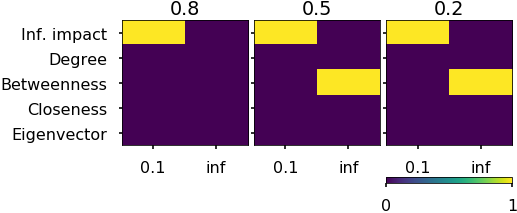

In [13]:
conditions, npulse, ntemps = overlap.shape
print(overlap.shape)
# show jaccard scores

hr = np.ones(3)
hr[-2] = .1
hr[-1] = .05
gs = dict(height_ratios = hr)
fig, ax = plt.subplots(3, ntemps,\
                       figsize = (7,3),\
                      gridspec_kw = gs,\
                       sharey = 'row')

cLabels = ['Inf. impact', *[i.capitalize() for i in centralities.keys()]]
print(cLabels)
ratios = setting.get('equilibrium').get('ratios').keys()
ratios = list(ratios)
xr = np.arange(pulses.size)

yr = np.arange(conditions - 1)
w = np.diff(yr)[0] /(yr.size *.5)
print(w)
print(overlap.shape)
for tidx, axi in enumerate(ax[0]):
#     print(tidx, overlap[1:,...,tidx])
    h = axi.imshow(overlap[1:, :, tidx],\
                   aspect = 'auto',\
                   vmin = 0, vmax = 1, extent = [0, xr.size, yr.size, 0])
    axi.set_xticks(xr + .5)
    axi.set_xticklabels(pulses)
    
    if tidx == 0:
        axi.set_yticks(yr + .5)
    
    axi.set_yticklabels(cLabels)
    axi.set_title(ratios[tidx])
for axi in ax[1:].flat:
    axi.axis('off')

print(overlap[1:, :, -1])
# ax[0, -1].set_yticks(yr)
    
ax.flat[-1].axis('on')
ax.flat[-1].set_xlim(0, 1)
fig.colorbar(h, cax = ax.flat[-1], orientation = 'horizontal', ticks = (0, 1))
fig.subplots_adjust(wspace = .05)
fig.savefig('pyscho_jaccard.svg')
fig.show()

(6, 2, 3)
(3, 3)


<ipython-input-14-3aaeb1aac38f>:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


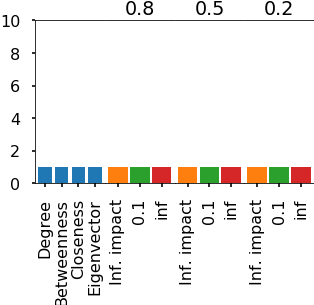

In [14]:
# plot driver sizes
conditions, npulse, ntemps = driverSizes.shape
print(driverSizes.shape)

# wr = np.ones(ntemps + 1)
# wr[1] = .1
# gs = dict(width_ratios = wr)
fig, ax = plt.subplots(1, ntemps + 1,\
#                       gridspec_kw = gs,\
                      figsize = (5, 3))
ax[0].bar(np.arange(conditions - 2), driverSizes[2:, 0, 0])
ax[0].set_ylim(0, 10)
ax[0].spines['right'].set_visible(0)
ax[0].set_xticks(np.arange(len(cLabels[:-1])))
ax[0].set_xticklabels(cLabels[1:], rotation = 90)




tmpSizes = np.zeros((npulse + 1, ntemps))
tmpSizes[1:] = driverSizes[0]
tmpSizes[0]  = driverSizes[1, 0]


# width = 1/len(tmpSizes.T)
width = 1/5

print(tmpSizes.shape)
xr = np.arange(0, 5) / width

dLabels = ['Inf. impact', *pulses.round(1)]
colors = plt.cm.tab10(range(len(tmpSizes) + 1))
for idx, axi in enumerate(ax[1:]):
    
    d = tmpSizes[..., idx]
#     print(d.shape)
    
    xr = []
    for jdx, di in enumerate(d):
#         print(jdx)
        xr.append(width * jdx)
        axi.bar(width * jdx,\
                height = di, width = .9 * width, \
                color = colors[jdx + 1])
#     axi.set_xticks(xr)
#     axi.set_xticklabels(dLabels, rotation = 90)
    axi.set_ylim(0, 10)
    axi.set_yticks([])
    axi.set_xticks(xr)
    axi.set_xticklabels(dLabels, rotation = 90)
    axi.spines['left'].set_visible(0)
    axi.set_title(ratios[idx])
    if idx < ntemps - 1:
        axi.spines['right'].set_visible(0)
#     axi.bar(np.arange(2), height = driverSizes[:2, ..., tidx], aspect = 'auto')
    if idx > 0:
        axi.set_yticklabels([])
#     axi.set_yticklabels(labels)
#     axi.set_xticklabels(pulses)
fig.subplots_adjust(wspace = 0)
fig.savefig('pyscho_driver.svg')
fig.show()


# boostrap results

In [78]:
print(ALLDRIVERS[0, 1])

{2: (2.000946800065857, 7.196188329185282e-07)}


In [88]:
# perform boostrap
# print(overlap.shape)
from Utils.stats import bootStrap, ratio 
tmp = overlap[1:]  
nconditions, npulse, ntemp = tmp.shape

tmp = np.moveaxis(tmp, 0, -1)
tmp = np.moveaxis(tmp, 0, 1)
total = int(1e5)

tmp = tmp.reshape(-1, nconditions)
batch = len(tmp)
boots = bootStrap(tmp, ratio, total, batch)


tmp = tmp.reshape(ntemp, npulse, nconditions)
batch = len(tmp)
hboots = bootStrap(tmp, ratio, \
                  total, batch)


BOOTS = np.concatenate((boots[:, None, :], hboots), axis = 1)
# BOOTS += np.random.rand(*BOOTS.shape) * 1e-16
print(tmp.shape, hboots.shape, boots.shape, BOOTS.shape)


# gest worst distributions
worst = abs(BOOTS.mean(0)).argmin(-1)
worst = np.array([BOOTS[...,idx, i] for idx, i in enumerate(worst)])
kdeFits = np.zeros((worst.shape[-1], 2))
for idx, di in enumerate(worst):
    kdeFits[idx] = kde =  norm.fit(di)
    print(f'KDE FIT {kde}')
    

../Utils/stats.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return x[...,[0]] / x[..., 1:]
../Utils/stats.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return x[...,[0]] / x[..., 1:]
../Utils/stats.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return x[...,[0]] / x[..., 1:]
../Utils/stats.py:78: RuntimeWarning: invalid value encountered in true_divide
  return x[...,[0]] / x[..., 1:]
../Utils/stats.py:78: RuntimeWarning: invalid value encountered in true_divide
  return x[...,[0]] / x[..., 1:]
../Utils/stats.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return x[...,[0]] / x[..., 1:]
../Utils/stats.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return x[...,[0]] / x[..., 1:]
../Utils/stats.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return x[...,[0]] / x[..., 1:]
../Utils/stats.py:78: RuntimeWarning: invalid value encountered in true_divide
  return x[...,[0]]

(3, 2, 5) (100000, 2, 4) (100000, 4) (100000, 3, 4)
KDE FIT (nan, nan)
KDE FIT (inf, nan)
KDE FIT (nan, nan)


[1.33164667 0.28437053]
[4.88301744e-16 1.20527925e-04 3.55544464e-04 7.99316057e-04
 1.61064035e-03 3.04651244e-03 5.50587297e-03 9.58151717e-03
 1.61143300e-02 2.62387756e-02 4.14028175e-02 6.33408020e-02
 9.39766276e-02 1.35239327e-01 1.88785925e-01 2.55647204e-01
 3.35838160e-01 4.28000568e-01 5.29162142e-01 6.34696846e-01
 7.38548488e-01 8.33735019e-01 9.13091381e-01 9.70148302e-01
 1.00000000e+00 1.00000000e+00 9.70148302e-01 9.13091381e-01
 8.33735019e-01 7.38548488e-01 6.34696846e-01 5.29162142e-01
 4.28000568e-01 3.35838160e-01 2.55647204e-01 1.88785925e-01
 1.35239327e-01 9.39766276e-02 6.33408020e-02 4.14028175e-02
 2.62387756e-02 1.61143300e-02 9.58151717e-03 5.50587297e-03
 3.04651244e-03 1.61064035e-03 7.99316057e-04 3.55544464e-04
 1.20527925e-04 0.00000000e+00]
[2. 0.]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


<ipython-input-87-0342f4681fc1>:87: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


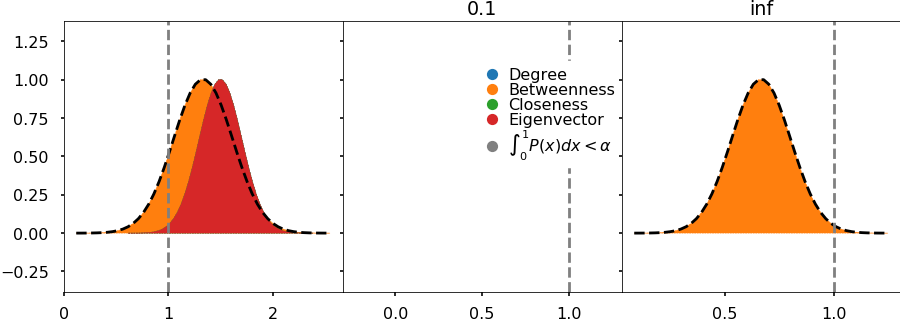

In [87]:
from statistics import NormalDist
from scipy.stats import norm
theta = 1
thetas = [1, 100]
xr = np.arange(1, 100, dtype = int)
n = xr.size

start = 1e-5
samples, aa, cc = BOOTS.shape
# ax.imshow(boots, aspect = 'auto')
# print(samples, aa, cc)
bbox_props = dict(boxstyle="circle",\
                        ec = 'gray', lw=2,\
                        pad = 0, \
                        fc = 'gray')


alpha = 0.01
titles = [' ', *pulses.round(1)]
%matplotlib inline
fig, ax = plt.subplots(1, aa, sharey = 'all',\
                      figsize = (15, 5))
for idx, axi in enumerate(ax.flat):
    for jdx in range(cc):
        tmpi = BOOTS[:, idx, jdx]
        dist = norm.fit(tmpi)
        lims = [norm(*dist).ppf(theta) for theta in (start, 1 - start)]
        xr = np.linspace(*lims)
        p  = norm(*dist).pdf(xr)
        p  = (p - p.min()) / (p.max() - p.min())
#         axi.set_xscale('log')
        axi.fill_between(xr, p, color = colors[jdx], linestyle = 'dashed', label = jdx)
    
    
    
    # visualize worst-case scenario
    worstFit = kdeFits[idx] 
    # pvalue
    pval = norm.cdf(1, *worstFit) # - norm.cdf(.5, *worstFit)
    
    # compute lims
    lims = [norm(*worstFit).ppf(theta) for theta in (start, 1 - start)]
    xr = np.linspace(*lims)
    
    print(worstFit)
    # plot distribution
    p  = norm(*worstFit).pdf(xr)
    p  = (p - p.min()) / (p.max() - p.min())
    
    print(p)
    axi.plot(xr, p, linestyle = 'dashed', color = 'k')
    if pval < alpha:
        axi.annotate(' ', (1,  axi.axis()[-1]/2),\
                    fontsize = 15,\
                    verticalalignment = 'center',\
                    horizontalalignment = 'center',\
                    bbox  = bbox_props,\
#                         textcoords = 'axes fraction',\
                    )
    axi.set_title(titles[idx])
    axi.axvline(1, linestyle = 'dashed', color = 'gray')
#     axi.set_xscale('log')

colors = plt.cm.tab10(range(4))
elems = [] 
for idx, c in enumerate(centralities):
    elems.append(plt.Line2D([], [], marker = 'o', linestyle = 'none',\
                           color = colors[idx],\
                           label = c.capitalize()))
elems.append(plt.Line2D([], [], marker = 'o', linestyle = 'none',\
                       color = 'gray',\
                       label = '$\int_0^1 P(x) dx < \\alpha$'))
ax[1].legend(\
        handles = elems, loc = 'upper right',\
        bbox_to_anchor = (1, .85),\
        borderaxespad = 0,\
        handletextpad = 0, frameon = 1,\
        edgecolor = 'white',\
        facecolor = 'white',\
        framealpha = 1,\
        labelspacing = 0)
          
fig.subplots_adjust(wspace = 0)
fig.savefig('psycho_bootstrap.svg', transparent = 1,\
           bbox_inches = 'tight',\
           pad_inches = 0)
fig.show()
        
# print(overlap[1:, :, -1], overlap.shape)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(12, 20, 3, 3, 49)
{2: (5.695508923212718, 0.003097399341328293)}
sleep
{7: (11.61350614718974, 0.004964531921837389)}
sad
{7: (6.473791760065524, 0.00040363376093132823)}
sad
{2: (6.993899272812367, 0.026772236838546605)}
sleep
{7: (14.416981255612516, 0.04114089296015738)}
sad
{7: (9.257612293501948, 0.011082918363953692)}
sad
{4: (12.591290745359453, 0.07397142527489126)}
lonely
{8: (9.026883808540877, 0.0001234413314193753)}
dislike
{8: (7.069149897749861, 1.4609632282326509e-05)}


<ipython-input-20-8ce097a88edb>:48: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axi.annotate(pulses.round(2)[p - 1], (.9, .5), textcoords = 'axes fraction', \


dislike


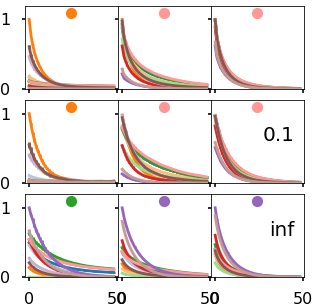

In [20]:
# get dataa

ALLDRIVERS = np.array([i for i in alldrivers.values()]).squeeze()[..., 0]

from scipy.stats import sem
tmp = np.array([i for i in rdata.values()]).squeeze()
pulses = np.array(setting.get('pulseSizes'))
nodes, ntrials, npulse, ntemps, deltas = tmp.shape

gs = dict()
%matplotlib widget
fig, ax = plt.subplots(npulse, ntemps, gridspec_kw = gs, \
                      figsize = (5, 5),\
                       sharex = 'all', sharey = 'col')

print(tmp.shape)
colors = plt.cm.tab20(range(nodes))
xr = np.arange(deltas)
for p in range(npulse):
    for t in range(ntemps):
        axi = ax[p, t]
        d = tmp.mean(1)[..., p, t, :]
        e = sem(tmp, 1)[..., p, t, :]
        
        drivers = ALLDRIVERS[p, t]
        
        print(drivers)
        elems = []
        for nodeLabel, node in m.mapping.items():
            
            if node in drivers.keys():
                print(nodeLabel)
                elem = plt.Line2D([], [], marker = 'o', linestyle = 'none', \
                                  color = colors[node])
                elems.append(elem)
                
            axi.errorbar(xr, d[node], yerr = 2 * e[node], color = colors[node], \
                         )
            
        axi.legend(handles = elems, fancybox = 0,\
                  bbox_to_anchor = (0.5, .9), loc = 'center', ncol = 10, \
                   framealpha = 0, borderaxespad = 0, handletextpad = 0)
        if t > 0:
            axi.set_yticklabels([])
        axi.set_ylim(0, 1.2)
#         axi.set_xlim(0, 5)
        if t == ntemps - 1 and p > 0:
            axi.annotate(pulses.round(2)[p - 1], (.9, .5), textcoords = 'axes fraction', \
                        horizontalalignment = 'right', fontsize = 20)
fig.subplots_adjust(wspace = 0,  hspace = 0.13)
fig.savefig('pyscho_time.svg')
fig.show()

In [90]:
print(m.rmapping)

s = ALLDRIVERS.shape
for (i, j) in product(*map(range, s)):
    print(i,j)
    for k in ALLDRIVERS[i, j]:
        print(k, m.rmapping[k])
#     print(ALLDRIVERS[i,j].keys(), i, j)

{0: 'depr', 1: 'effort', 2: 'sleep', 3: 'happy', 4: 'lonely', 5: 'enjoy', 6: 'appet', 7: 'sad', 8: 'dislike', 9: 'getgo', 10: 'loss', 11: 'unfr'}
0 0
2 sleep
0 1
2 sleep
0 2
10 loss
1 0
2 sleep
1 1
2 sleep
1 2
9 getgo
2 sleep
10 loss
2 0
8 dislike
0 depr
2 1
8 dislike
2 2
8 dislike


# Time data widget

In [38]:

import ipywidgets as widgets
from scipy.stats import sem
from Utils.plotting import addGraphPretty
# dataSlider = widgets.SelectionSlider(options = data.keys())
dataSlider = widgets.Select(options = data.keys())
tempSlider = widgets.IntSlider(min = 0, max = 2)

print(npulse)
pulseSlider = widgets.IntSlider(min = 1, max = npulse)


%matplotlib notebook
fig, (left, right) = plt.subplots(1, 2, figsize = (10, 7), sharey = 'all')
mainax = fig.add_subplot(111, frameon = 0,\
                        xticks = [],\
                        yticks = [])
mainax.set_xlabel('Time[step]', labelpad = 30)
# inax.axis('off')
@widgets.interact(dataName = dataSlider, \
                  temp = tempSlider, \
                  pulse = pulseSlider)
def update(dataName, temp, pulse):
    d = rdata.get(dataName)
    
    for idx, i in enumerate(data.keys()):
        if i == dataName:
            break
    print(alldrivers[dataName].shape)
    a = aucs.get(dataName)[..., pulse, temp].mean(1)
    print(a, aucs[dataName].shape)
    drivers = alldrivers[dataName][pulse, temp, 0]
    print(drivers)
    mainax.set_title(dataName + "\n" + str(drivers.keys()))
    g = settings.get(dataName).get('graph')

    
    nodes, trials, pulses, temps, deltas = d.shape
    colors = plt.cm.tab20(range(nodes))
    means = d.mean(1)
    sems  =  2 * np.std(d, axis = 1)
    xr = np.arange(d.shape[-1])
    
    left.cla(); right.cla()
    
    inax = right.inset_axes([.4, 0.4, .6, .6])
    addGraphPretty(g, ax = inax)
    inax.axis('off')
    for node in range(nodes):
        left.errorbar(xr, means[node, 0, temp], \
                      sems[node, 0, temp], \
                      color = colors[node],\
                      label = node)
        right.errorbar(xr, means[node, pulse, temp], \
                       sems[node, pulse, temp], \
                       color = colors[node],\
                       label = node)
#         left.set_yscale('log')
#         right.set_yscale('log')
    
    elems = [\
             plt.Line2D([], [], color = colors[node], \
                  label = f'{node}{"*" if node in drivers else ""}', \
                  marker = 'o', linestyle = 'None')\
                  for node in range(nodes)\
          ]
    left.set_ylabel(r'$I(s_i^{t_0 + t} ; S^{t_0})$')
    right.set_ylabel(r"$D_{KL}(P' \vert \vert P)$")
    right.legend(handles = elems, \
                 bbox_to_anchor = (1.0, 1), loc = 'upper left',\
                title = 'Node', title_fontsize = 20,\
                frameon = 0,\
                borderaxespad = 0)
fig.show(0)

3


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(Select(description='dataName', options=('Data/psycho/1548025318.5751357',), value='Data/…

# fit error plots

<ipython-input-106-deacb1dd8f4f>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


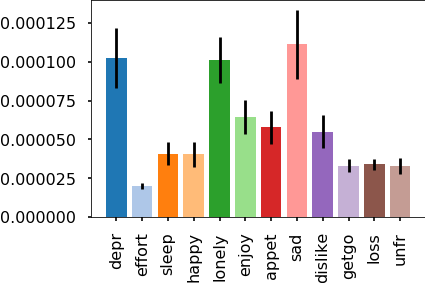

In [106]:
from pipeline import func

c = np.array([i for i in coeffs.values()]).squeeze()
d = np.array([i for i in rdata.values()]).squeeze()


s = c.shape # nodes trials pulse temp coeffs
ss = d.shape # nodes trials pulse, temp deltas
c = c.reshape(s[0], -1, s[-1])
d = d.reshape(ss[0], -1, ss[-1])
deltas = ss[-1]
xr = np.arange(deltas)

N = c.shape[1]
errors = np.zeros((s[0], N))
for node in range(s[0]):
    for trial in range(N):
        di = d[node, trial]
        C = c[node, trial]
        error = np.mean((func(xr, *C) - di)**2)
        errors[node, trial] = error
        
nodes = np.arange(s[0])

colors = plt.cm.tab20(range(nodes.size))
fig, ax = plt.subplots()
for node in nodes:
    ax.errorbar(node, errors[node].mean(), sem(errors[node]), \
                linestyle = 'none', capthick = 5, color = 'black',\
               )
    ax.bar(node, errors[node].mean(), color = colors[node])
ax.set_xticks(nodes)
ax.set_xticklabels([m.rmapping[i] for i in nodes], rotation = 90)
fig.savefig('MSE_psycho.pdf')
fig.show()